In [1]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import json
import argparse
import copy
import h5py
import torch

import warnings, os

from matplotlib.colors import LogNorm
import matplotlib.ticker as ticker

from scipy.ndimage import gaussian_filter

from power import compute_power, compute_cylindrical_power

from astropy.cosmology import Planck18 as cosmo
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=67.74, Om0=0.3089)
hlittle = cosmo.H0.value / 100

from astropy import units as u

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

colors_base = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors = [colors_base[0], "black", "orange", colors_base[3], colors_base[3]]


def my_savefig(fsave):
    if fsave is not None:
        plt.tight_layout()
        plt.savefig(fsave, dpi=300)
        print("Saved figure to", fsave)

def load_data(fname, ix=0, iy=0, iz=0, nx=None, ny=None, nz=None, dataname="intensity0"):
    print("Load {} (dataset: {})".format(fname, dataname))
    with h5py.File(f"{fname}", "r") as f:
        intensity = f[dataname][:]
        header = {key: f.attrs[key] for key in f.attrs}

    if nx is None:
        nx = intensity.shape[0]
    if ny is None:
        ny = intensity.shape[1]
    if nz is None:
        nz = intensity.shape[2]
    intensity = intensity[ix:ix+nx, ix:ix+ny, ix:ix+nz]
    return intensity, header


def plot_power(k_values, power, ax=None, label=None, ls=None, color=None, zorder=0, alpha=None, lw=None, with_factor=False):
    if ax is None:
        ax = plt.gca()

    if with_factor:
        power = power *  (k_values**3) / (2 * np.pi**2)  # Convert to Mpc^3 units
    else:
        power = power

    ax.plot(k_values[1:], power[1:], label=label, ls=ls, color=color, zorder=zorder, alpha=alpha, lw=lw)
    #plt.errorbar(k_values, power, yerr=np.sqrt(var), fmt="o")

# Load data

In [4]:
### Load data
model_name = "transformer1"

snapshot_number = 33
base_dir = "../dataset/generated_data"
output_dir = "../dataset/generated_data/figures"
os.makedirs(output_dir, exist_ok=True)

sim_name = "TNG300-1"
label = ".threshold1e-3"
#label = ""
prefix_list = ["group.{}.{:d}{}".format(sim_name, snapshot_number, label), 
               "subgroup.{}.{:d}{}".format(sim_name, snapshot_number, label), 
               "group.data_cube.{:d}{}.{}.seed0".format(snapshot_number, label, model_name), 
               "group_dm_only.data_cube.{:d}{}.{}.seed0.factor0.9".format(snapshot_number, label, model_name), 
               "pinocchio.run2.data_cube.{:d}{}.{}.factor0.9".format(snapshot_number, label, model_name)
            ]
titles = ["TNG (Halo)", "TNG", "Generated", "Generated (DM-only)", "Pinocchio"] 

titles_rsd = [ f"{t} with RSD" for t in titles ]
data_list = []
data_rsd_list = []
cat_list = []
cat_rsd_list = []

header_list = []
header_rsd_list = []   
for p in prefix_list:
    fname = "{}/{}.h5".format(base_dir, p)
    intensity, header = load_data(fname, dataname="intensity0")
    data_list.append(intensity)
    header_list.append(header)

    intensity, header = load_data(fname, dataname="intensity1")
    
    data_rsd_list.append(intensity)
    header_rsd_list.append(header)

    """
    path = "{}/{}.cat.txt".format(base_dir, p)
    if os.path.exists(path):
        print(path)
        cat = np.loadtxt(path)
        cat_list.append(cat)
    path = "{}/{}.rsd.cat.txt".format(base_dir, p)
    if os.path.exists(path):
        print(path)
        cat_rsd = np.loadtxt(path)
        cat_rsd_list.append(cat_rsd)
    """

diff = [ d - d_rsd for d, d_rsd in zip(data_list, data_rsd_list) ]

Load ../dataset/generated_data/group.TNG300-1.33.threshold1e-3.h5 (dataset: intensity0)
Load ../dataset/generated_data/group.TNG300-1.33.threshold1e-3.h5 (dataset: intensity1)
Load ../dataset/generated_data/subgroup.TNG300-1.33.threshold1e-3.h5 (dataset: intensity0)
Load ../dataset/generated_data/subgroup.TNG300-1.33.threshold1e-3.h5 (dataset: intensity1)
Load ../dataset/generated_data/group.data_cube.33.threshold1e-3.transformer1.seed0.h5 (dataset: intensity0)
Load ../dataset/generated_data/group.data_cube.33.threshold1e-3.transformer1.seed0.h5 (dataset: intensity1)
Load ../dataset/generated_data/group_dm_only.data_cube.33.threshold1e-3.transformer1.seed0.factor0.9.h5 (dataset: intensity0)
Load ../dataset/generated_data/group_dm_only.data_cube.33.threshold1e-3.transformer1.seed0.factor0.9.h5 (dataset: intensity1)


Load ../dataset/generated_data/pinocchio.run2.data_cube.33.threshold1e-3.transformer1.factor0.9.h5 (dataset: intensity0)
Load ../dataset/generated_data/pinocchio.run2.data_cube.33.threshold1e-3.transformer1.factor0.9.h5 (dataset: intensity1)


# Show images

TNG 1368435.7881193443
Generated 1368435.7881193443
Generated (DM-only) 1368435.7881193443
Saved figure to ../dataset/generated_data/figures/intensity_maps.pdf
TNG with RSD 1368435.7881193443
Generated with RSD 1368435.7881193443
Generated (DM-only) with RSD 1368435.7881193443
Saved figure to ../dataset/generated_data/figures/intensity_maps_rsd.pdf
TNG 1368435.7881193443
Generated 1368435.7881193443
Generated (DM-only) 1368435.7881193443
Saved figure to ../dataset/generated_data/figures/intensity_maps_diff.pdf


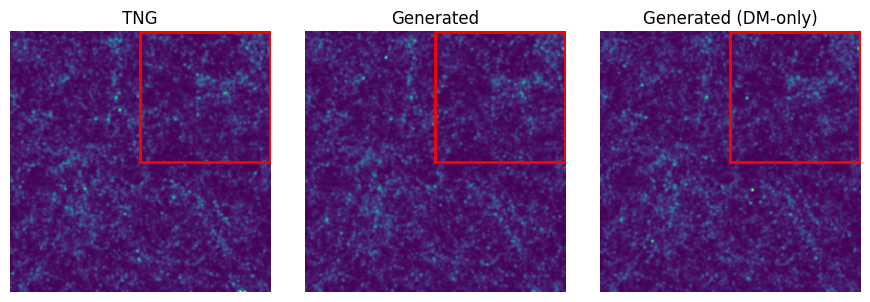

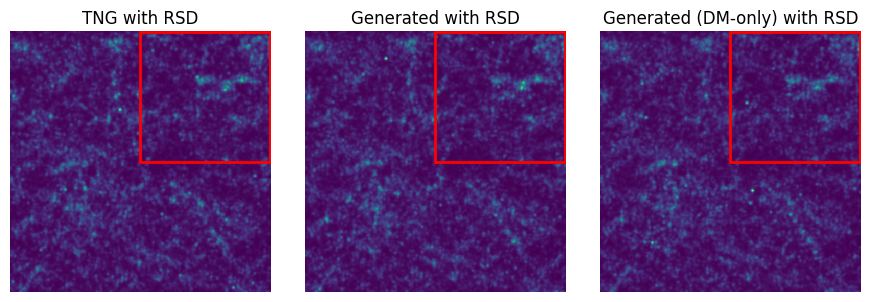

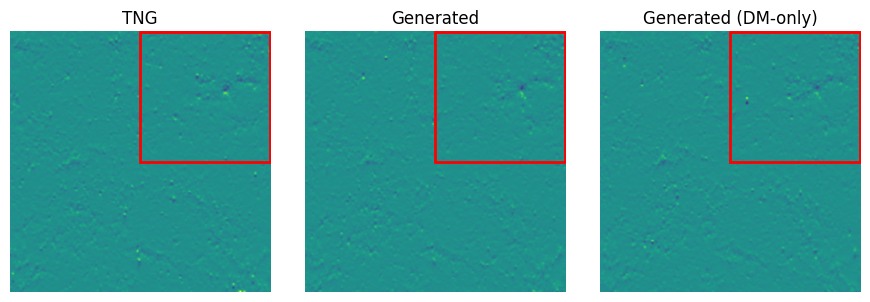

In [32]:
def show_images(data_list, titles, fsave=None, vmin=None, vmax=None, norm=None, xmin=0, ymin=0, zmin=0, nx=-1, ny=-1, nz=-1, sigma=2):

    plt.figure(figsize=(len(data_list) * 3, 3))
    for i, d in enumerate(data_list):        
        image = d[xmin:xmin+nx, ymin:ymin+ny, zmin:zmin+nz].mean(axis=1)
        image = gaussian_filter(image, sigma=sigma)

        plt.subplot(1, len(data_list), i+1)
        plt.title(titles[i])
        plt.imshow(image.T, origin="lower", interpolation="none", vmin=vmin, vmax=vmax, norm=norm)

        plt.xticks([])
        plt.yticks([])
        #plt.colorbar()
        
        ax = plt.gca()
        ax.set_aspect("equal")
        
        boxsize_x, boxsize_y = image.shape
        x0 = int(boxsize_x * 0.5)
        y0 = int(boxsize_y * 0.5)
        zoom_size = int(boxsize_x * 0.5)
        ax.add_patch(plt.Rectangle((x0, y0), zoom_size-1, zoom_size-1, edgecolor='red', facecolor='none', linewidth=2))

        ax.set_frame_on(False)
        
        print(titles[i], np.sum(intensity))
        
    my_savefig(fsave)
        
_, boxsize_y, _ = data_list[0].shape
ymin= int(0.5*boxsize_y)
ny = int(0.5*boxsize_y)

fsave = "{}/intensity_maps.pdf".format(output_dir)
show_images(data_list[1:4], titles[1:4], fsave=fsave, ymin=ymin, ny=ny, vmin=0, vmax=0.13)
#show_images(fname_list, titles, fsave, norm=LogNorm(vmin=0.1, vmax=100))

fsave = "{}/intensity_maps_rsd.pdf".format(output_dir)
show_images(data_rsd_list[1:4], titles_rsd[1:4], fsave=fsave, ymin=ymin, ny=ny, vmin=0, vmax=0.13)
#show_images(fname_list, titles, fsave, norm=LogNorm(vmin=0.1, vmax=100))

fsave = "{}/intensity_maps_diff.pdf".format(output_dir)
show_images(diff[1:4], titles[1:4], fsave=fsave, ymin=ymin, ny=ny, vmin=-0.13, vmax=0.13)

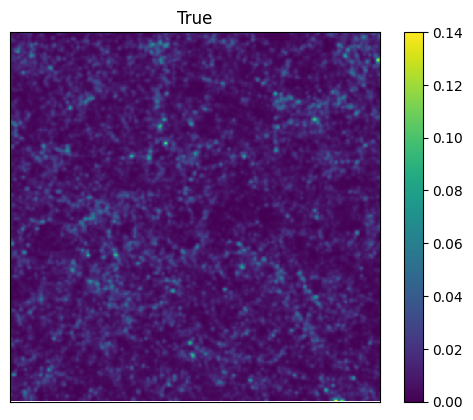

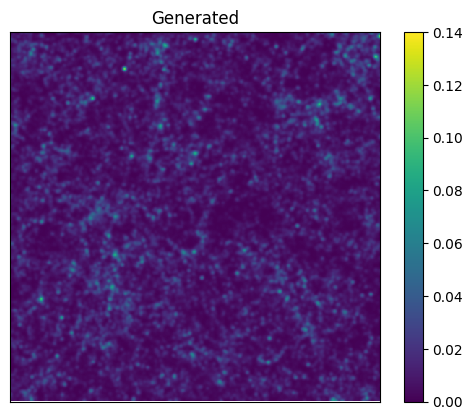

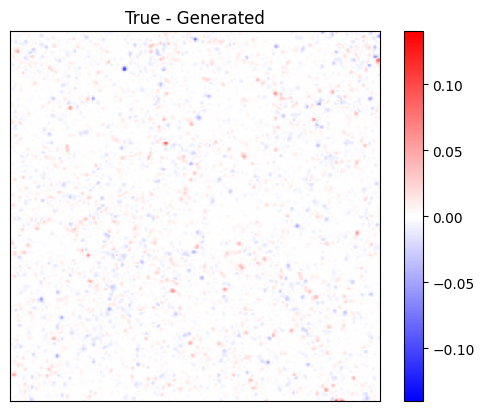

In [4]:
plt.figure()
plt.title("True")
image = data_list[1][:,ymin:ymin+ny,:].mean(axis=1)
image = gaussian_filter(image, sigma=2)
plt.imshow(image.T, vmin=0.0, vmax=0.14, origin="lower", interpolation="none", )
plt.xticks([])
plt.yticks([])
plt.colorbar()

plt.figure()
plt.title("Generated")
image = data_list[2][:,ymin:ymin+ny,:].mean(axis=1)
image = gaussian_filter(image, sigma=2)
plt.imshow(image.T, vmin=0, vmax=0.14, origin="lower", interpolation="none", )
plt.xticks([])
plt.yticks([])
plt.colorbar()

plt.figure()
plt.title("True - Generated")
image = (data_list[1] - data_list[2])[:,ymin:ymin+ny,:].mean(axis=1)
image = gaussian_filter(image, sigma=2)
plt.imshow(image.T, vmin=-0.14, vmax=0.14, cmap="bwr", origin="lower", interpolation="none", )
plt.xticks([])
plt.yticks([])
plt.colorbar()

Saved figure to ../dataset/generated_data/figures/intensity_maps_pinocchio.pdf
Saved figure to ../dataset/generated_data/figures/intensity_maps_pinocchio_rsd.pdf


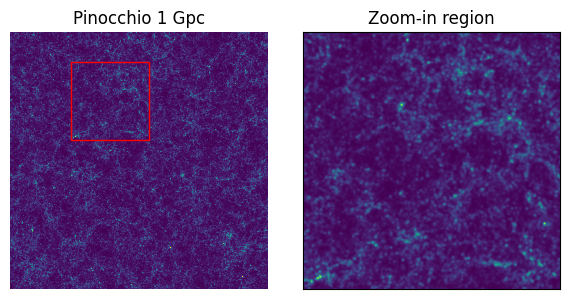

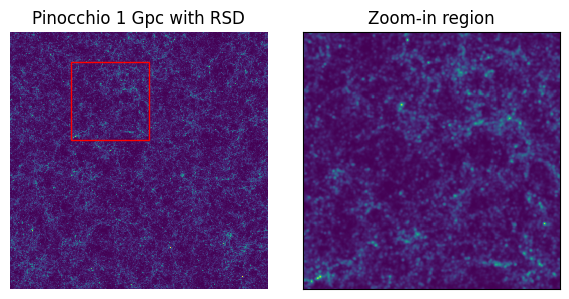

In [5]:
zoom_size = data_list[0].shape[0]
def show_images_with_zoom(data, title, dy_factor=0.5, fsave=None):
    image = data[:,:int(zoom_size*dy_factor),:].mean(axis=1)
    image = gaussian_filter(image, sigma=2)
    image = image.T 

    x0, y0 = 400, 200  # upper left corner of the zoomed area
    zoom = image[y0:y0+zoom_size, x0:x0+zoom_size]

    fig, axes = plt.subplots(1, 2, figsize=(6, 3))

    axes[0].imshow(image, vmin=0, vmax=0.13, interpolation="none")
    axes[0].set_title(title)
    axes[0].add_patch(plt.Rectangle((x0, y0), zoom_size, zoom_size, edgecolor='red', facecolor='none', linewidth=1))
    axes[0].set_aspect('equal')
    axes[0].axis('off')

    axes[1].imshow(zoom, vmin=0, vmax=0.13, interpolation="none")
    axes[1].set_title("Zoom-in region")
    #axes[1].add_patch(plt.Rectangle((0, 0), zoom_size, zoom_size, edgecolor='red', facecolor='none', linewidth=3, zorder=10))
    #for spine in axes[1].spines.values():
    #    spine.set_edgecolor('red')
    #    spine.set_linewidth(1) 
    axes[1].set_aspect('equal')
    axes[1].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

    my_savefig(fsave)

fsave = "{}/intensity_maps_pinocchio.pdf".format(output_dir)
show_images_with_zoom(data_list[4], title="Pinocchio 1 Gpc", fsave=fsave)

fsave = "{}/intensity_maps_pinocchio_rsd.pdf".format(output_dir)
show_images_with_zoom(data_list[4], title="Pinocchio 1 Gpc with RSD", fsave=fsave)

# Power Spectrum

In [34]:
### Compute power spectrum
k_list = []
power_list = []
for data, header in zip(data_list[:4], header_list):
    boxsize = header["boxsize"] / hlittle # Mpc
    voxel_size = boxsize ** 3 / data.shape[0] / data.shape[1] / data.shape[2]

    nhalf = int(len(data)/2)
    data = data[:-nhalf, :-nhalf, :-nhalf]
    boxsize = boxsize / 2
    power, k, var = compute_power(data / voxel_size, boxlength=boxsize, log_bins=True)
    
    k_values = 0.5 * (k[1:] + k[:-1])
    power_list.append(power)
    k_list.append(k_values)

k_rsd_list = []
power_rsd_list = []
for data, header in zip(data_rsd_list[:4], header_rsd_list):
    boxsize = header["boxsize"] / hlittle
    voxel_size = boxsize ** 3 / data.shape[0] / data.shape[1] / data.shape[2]
    
    nhalf = int(len(data)/2)
    data = data[:-nhalf, :-nhalf, :-nhalf]
    boxsize = boxsize / 2
    power, k, var = compute_power(data / voxel_size, boxlength=boxsize, log_bins=True)

    k_values = 0.5 * (k[1:] + k[:-1])
    power_rsd_list.append(power)
    k_rsd_list.append(k_values)

for i in range(len(power_list)):
    fout = "{}/power_{:d}_test.txt".format(output_dir, i)
    with open(fout, "w") as f:
        for j in range(len(k_list[i])):
            f.write("{:.4e} {:.4e} {:.4e}\n".format(k_list[i][j], power_list[i][j], power_rsd_list[i][j]))

    print("output {}".format(fout))
    

output ../dataset/generated_data/figures/power_0_test.txt
output ../dataset/generated_data/figures/power_1_test.txt
output ../dataset/generated_data/figures/power_2_test.txt
output ../dataset/generated_data/figures/power_3_test.txt


Saved figure to ../dataset/generated_data/figures/power_spectrum_test.pdf


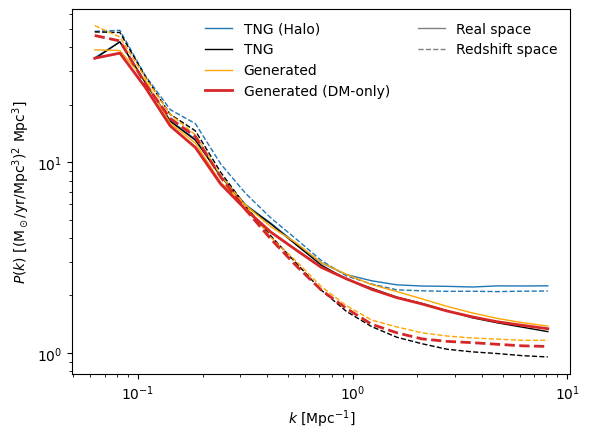

In [35]:
def compare_power(id_list, fsave, lw_list=None, with_factor=False, **kwargs):

    plt.figure(figsize=(6, 4.5))
    alpha = [1, 1, 1, 1, 1]

    for count, i in enumerate(id_list):
        data = np.loadtxt("{}/power_{}_test.txt".format(output_dir, str(i) if i < 4 else "pinocchio"))
        k = data[:,0]
        power = data[:,1]
        power_rsd = data[:,2]
        
        plot_power(k, power, label=titles[i], ls="solid", color=colors[i], zorder=i, alpha=alpha[i], with_factor=with_factor, lw=lw_list[i])
        plot_power(k, power_rsd, ls="dashed", color=colors[i], zorder=i, alpha=alpha[i], with_factor=with_factor, lw=lw_list[i])
    
    plt.xlabel(r"$k \ [\rm Mpc^{-1}]$")

    if with_factor:
        plt.ylabel(r"$k^3P(k)/2\pi^2\ [({\rm M_\odot / yr /Mpc^3})^2]$")
    else:
        #plt.ylabel(r"$P(k)\ [({\rm M_\odot / yr)^2 / Mpc^3]}$")
        plt.ylabel(r"$P(k)\ [({\rm M_\odot / yr / Mpc^3)^2 \ Mpc^3]}$")
    plt.yscale("log")
    plt.xscale("log")

    xlim = plt.xlim()
    ylim = plt.ylim()

    plt.plot([0, 1], [ylim[0]*0.1, ylim[0]*0.1], color="gray", ls="solid", lw=1, label="Real space")
    plt.plot([0, 1], [ylim[0]*0.1, ylim[0]*0.1], color="gray", ls="dashed", lw=1, label="Redshift space")
    plt.xlim(xlim)
    plt.ylim(ylim)
    
    ax = plt.gca()
    ax.legend(frameon=False, ncol=2)

    if len(id_list) > 3:
        leg = ax.get_legend()
        handles = leg.legend_handles
        labels = [t.get_text() for t in leg.get_texts()]
        dummy, = ax.plot([],[],alpha=0)
        handles.append(dummy)
        labels.append("")
        ax.legend(handles, labels, ncol=2, frameon=False)
        
    my_savefig(fsave)

### Show Power spectrum for test region
fsave = "{}/power_spectrum_test.pdf".format(output_dir)
compare_power([0, 1, 2, 3], fsave=fsave, lw_list=[1,1,1,2])

Saved figure to ../dataset/generated_data/figures/power_spectrum_test_diff.pdf


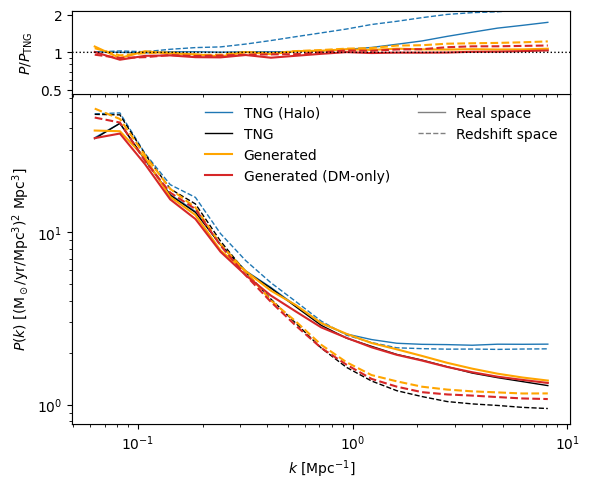

In [36]:
with_factor = False
def compare_power(id_list, fsave, lw_list=None, **kwargs):
    import matplotlib.gridspec as gridspec
    fig = plt.figure(figsize=(6, 5))
    
    gs = gridspec.GridSpec(2,1, height_ratios=[1,4])
    gs.update(hspace=0)
    plt.xticks([])
    plt.yticks([])

    ax = fig.add_subplot(gs[1])
    ax_diff = fig.add_subplot(gs[0])

    alpha = [1, 1, 1, 1, 1]
    
    for count, i in enumerate(id_list):
        data = np.loadtxt("{}/power_{}_test.txt".format(output_dir, str(i) if i < 4 else "pinocchio"))
        k = data[:,0]
        power = data[:,1]
        power_rsd = data[:,2]
        
        plot_power(k, power, ax=ax, label=titles[i], ls="solid", color=colors[i], zorder=i, alpha=alpha[i], with_factor=with_factor, lw=lw_list[i])
        plot_power(k, power_rsd, ax=ax, ls="dashed", color=colors[i], zorder=i, alpha=alpha[i], with_factor=with_factor, lw=lw_list[i])

        
    ax.set_xlabel(r"$k \ [\rm Mpc^{-1}]$")

    if with_factor:
        ax.set_ylabel(r"$k^3P(k)/2\pi^2\ [({\rm M_\odot / yr /Mpc^3})^2]$")
    else:
        #plt.ylabel(r"$P(k)\ [({\rm M_\odot / yr)^2 / Mpc^3]}$")
        ax.set_ylabel(r"$P(k)\ [({\rm M_\odot / yr / Mpc^3)^2 \ Mpc^3]}$")
    ax.set_yscale("log")
    ax.set_xscale("log")

    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    ax.plot([0, 1], [ylim[0]*0.1, ylim[0]*0.1], color="gray", ls="solid", lw=1, label="Real space")
    ax.plot([0, 1], [ylim[0]*0.1, ylim[0]*0.1], color="gray", ls="dashed", lw=1, label="Redshift space")
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
    ax.legend(frameon=False, ncol=2)

    if len(id_list) > 3:
        leg = ax.get_legend()
        handles = leg.legend_handles
        labels = [t.get_text() for t in leg.get_texts()]
        dummy, = ax.plot([],[],alpha=0)
        handles.append(dummy)
        labels.append("")
        ax.legend(handles, labels, ncol=2, frameon=False)
        
    data = np.loadtxt("{}/power_1_test.txt".format(output_dir, str(i) if i < 4 else "pinocchio"))
    
    power_base = data[:,1]
    power_base_rsd = data[:,2]

    for count, i in enumerate(id_list):
        data = np.loadtxt("{}/power_{}_test.txt".format(output_dir, str(i) if i < 4 else "pinocchio"))
        k = data[:,0]
        power = data[:,1]
        power_rsd = data[:,2]
        
        if i != 1:
            plot_power(k, power/power_base, ax=ax_diff, label=titles[i], ls="solid", color=colors[i], zorder=i, alpha=alpha[i], with_factor=with_factor, lw=lw_list[i])
            plot_power(k, power_rsd/power_base_rsd, ax=ax_diff, ls="dashed", color=colors[i], zorder=i, alpha=alpha[i], with_factor=with_factor, lw=lw_list[i])

    ax_diff.plot([-1, xlim[0],xlim[1]], [-1,1,1], ls="dotted", color=colors[1], zorder=i, alpha=alpha[1], lw=1)

    ax_diff.set_xlim(xlim)
    ax_diff.set_xscale("log")
    ax_diff.set_xticks([])

    ax_diff.set_yscale("log")
    ax_diff.set_ylim(10**(-0.33),10**0.33)

    ax_diff.set_yticks([0.5, 1, 2])
    ax_diff.set_yticklabels(["0.5", "1", "2"])
    import matplotlib.ticker as ticker
    ax_diff.yaxis.set_minor_formatter(ticker.NullFormatter())

    ax_diff.set_ylabel(r"$P/P_{\rm TNG}$")

    my_savefig(fsave)

fsave = "{}/power_spectrum_test_diff.pdf".format(output_dir)
compare_power([0, 1, 2, 3], fsave=fsave, lw_list=[1,1,1.5,1.5])

Saved figure to ../dataset/generated_data/figures/power_spectrum_pinocchio.pdf


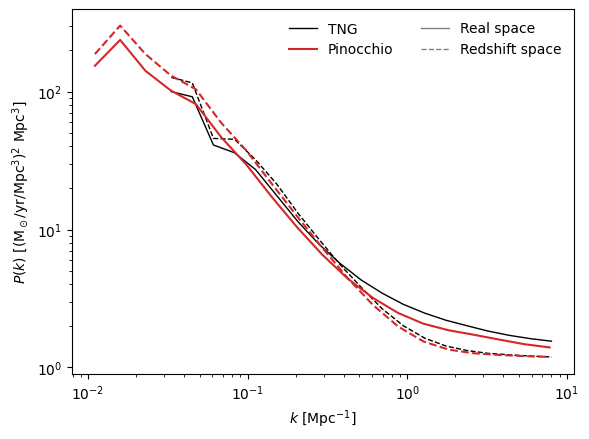

In [6]:
def compare_power(id_list, fsave, lw_list=None, with_factor=False, **kwargs):

    plt.figure(figsize=(6, 4.5))
    alpha = [1, 1, 1, 1, 1]

    for count, i in enumerate(id_list):
        data = np.loadtxt("{}/power_{}.txt".format(output_dir, str(i) if i < 4 else "pinocchio_factor0.9"))
        k = data[:,0]
        power = data[:,1]
        power_rsd = data[:,2]
        
        plot_power(k, power, label=titles[i], ls="solid", color=colors[i], zorder=i, alpha=alpha[i], with_factor=with_factor, lw=lw_list[i])
        plot_power(k, power_rsd, ls="dashed", color=colors[i], zorder=i, alpha=alpha[i], with_factor=with_factor, lw=lw_list[i])
    
    plt.xlabel(r"$k \ [\rm Mpc^{-1}]$")

    if with_factor:
        plt.ylabel(r"$k^3P(k)/2\pi^2\ [({\rm M_\odot / yr /Mpc^3})^2]$")
    else:
        #plt.ylabel(r"$P(k)\ [({\rm M_\odot / yr)^2 / Mpc^3]}$")
        plt.ylabel(r"$P(k)\ [({\rm M_\odot / yr / Mpc^3)^2 \ Mpc^3]}$")
    plt.yscale("log")
    plt.xscale("log")

    xlim = plt.xlim()
    ylim = plt.ylim()

    plt.plot([0, 1], [ylim[0]*0.1, ylim[0]*0.1], color="gray", ls="solid", lw=1, label="Real space")
    plt.plot([0, 1], [ylim[0]*0.1, ylim[0]*0.1], color="gray", ls="dashed", lw=1, label="Redshift space")
    plt.xlim(xlim)
    plt.ylim(ylim)
    
    ax = plt.gca()
    ax.legend(frameon=False, ncol=2)

    if len(id_list) > 3:
        leg = ax.get_legend()
        handles = leg.legend_handles
        labels = [t.get_text() for t in leg.get_texts()]
        dummy, = ax.plot([],[],alpha=0)
        handles.append(dummy)
        labels.append("")
        ax.legend(handles, labels, ncol=2, frameon=False)
        
    my_savefig(fsave)

### Show Power spectrum for test region
fsave = "{}/power_spectrum_pinocchio.pdf".format(output_dir)
compare_power([1, 4], fsave=fsave, lw_list=[1,1,1,1,1.5])

In [ ]:
k_perp_list = []
k_para_list = []
power2d_list = []
for data, header in zip(data_list[:3], header_list):
    boxsize = header["boxsize"] / hlittle
    voxel_size = boxsize ** 3 / data.shape[0] / data.shape[1] / data.shape[2]
    power2d, k_perp, k_para, var = compute_cylindrical_power(data / voxel_size, boxlength=boxsize, nbins=12, log_bins=True, use_same_bins=True)

    power2d_list.append(power2d)
    k_perp_list.append(k_perp)
    k_para_list.append(k_para)

power2d_rsd_list = []
for data, header in zip(data_rsd_list[:3], header_rsd_list):
    boxsize = header["boxsize"] / hlittle
    voxel_size = boxsize ** 3 / data.shape[0] / data.shape[1] / data.shape[2]
    power2d, kx, ky, var = compute_cylindrical_power(data / voxel_size, boxlength=boxsize, nbins=12, log_bins=True, use_same_bins=True)

    power2d_rsd_list.append(power2d)

power.py:190: RuntimeWarning: invalid value encountered in divide


power.py:190: RuntimeWarning: invalid value encountered in divide


power.py:190: RuntimeWarning: invalid value encountered in divide


power.py:190: RuntimeWarning: invalid value encountered in divide


power.py:190: RuntimeWarning: invalid value encountered in divide


power.py:190: RuntimeWarning: invalid value encountered in divide


/tmp/ipykernel_1042641/1857567685.py:26: UserWarning: The following kwargs were not used by contour: 'ls'
  ax.contour(X, Y, power2d, levels=[1.5, 3, 10], colors="k", ls="dashed", alpha=0.5)
/tmp/ipykernel_1042641/485979937.py:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Saved figure to ../dataset/generated_data/figures/cylindrical_power_spectrum.pdf


/tmp/ipykernel_1042641/1857567685.py:26: UserWarning: The following kwargs were not used by contour: 'ls'
  ax.contour(X, Y, power2d, levels=[1.5, 3, 10], colors="k", ls="dashed", alpha=0.5)
/tmp/ipykernel_1042641/485979937.py:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Saved figure to ../dataset/generated_data/figures/cylindrical_power_spectrum_rsd.pdf


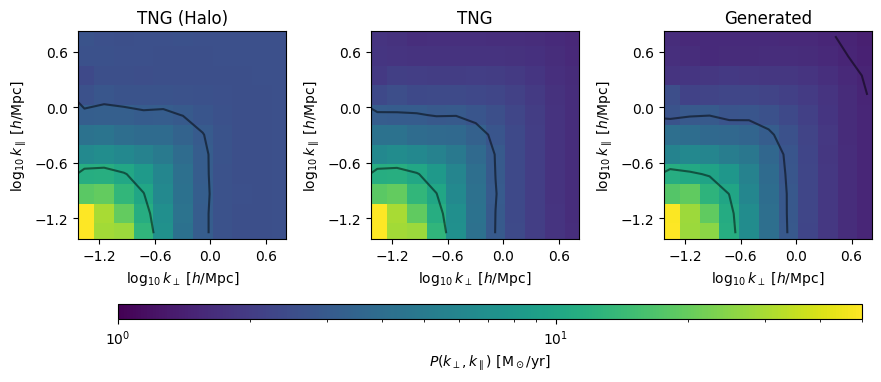

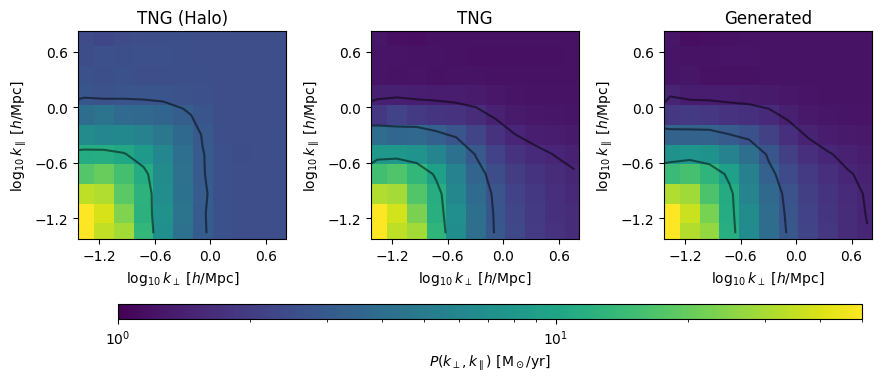

In [9]:
### Cylindrical power spectrum  
def plot_cylindrical_power(id_list, power2d_list, fsave=None):
    ndata = len(id_list)
    fig, axes = plt.subplots(1, ndata, figsize=(4*ndata, 4))
    plt.subplots_adjust(wspace=-0.9)

    for count, i in enumerate(id_list):
        k_perp = k_perp_list[i]
        k_para = k_para_list[i]
        power2d = power2d_list[i]
        
        log_k_perp = np.log10(k_perp)
        log_k_para = np.log10(k_para)

        ax = axes[count]
        ax.set_aspect("equal")
        ax.set_title(titles[i])
        

        vmin, vmax = 1, 50
        im = ax.pcolormesh(log_k_perp, log_k_para, power2d, shading="auto", norm=LogNorm(vmin=vmin, vmax=vmax))
        
        log_k_perp_values = 0.5 * (log_k_perp[1:] + log_k_perp[:-1])
        log_k_para_values = 0.5 * (log_k_para[1:] + log_k_para[:-1])
        X, Y = np.meshgrid(log_k_perp_values, log_k_para_values)
        ax.contour(X, Y, power2d, levels=[1.5, 3, 10], colors="k", ls="dashed", alpha=0.5)

        ax.set_xlabel(r"$\log_{10} k_\perp \ [h/ \rm Mpc]$")
        ax.set_ylabel(r"$\log_{10} k_\parallel \ [h/ \rm Mpc]$")

        ax.set_xlim(-1.43, 0.82)
        ax.set_ylim(-1.43, 0.82)

        ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=4))  # 最大4本
        ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=4))

    cbar = fig.colorbar(im, ax=axes, orientation="horizontal", aspect=50, pad=-0.45, shrink=0.8)
    cbar.set_label(r"$P(k_\perp, k_\parallel) \ [{\rm M_\odot / yr }]$")

    my_savefig(fsave)


plot_cylindrical_power([0, 1, 2], power2d_list, fsave="{}/cylindrical_power_spectrum.pdf".format(output_dir))
plot_cylindrical_power([0, 1, 2], power2d_rsd_list, fsave="{}/cylindrical_power_spectrum_rsd.pdf".format(output_dir))

# Voxel Intensity Distribution

In [23]:
def calc_vid(data, boxsize):
    voxel_size = boxsize**3 / (data.shape[0] * data.shape[1] * data.shape[2])
    volume = (boxsize / hlittle) **3 
    value = np.log10(data / voxel_size).flatten()
    hist = np.histogram(value, bins=30, range=(-0.5, 4.5), density=False)

    x = 10 **hist[1][:-1] 
    y = hist[0]/volume
    return x, y

1223742158.py:4: RuntimeWarning: divide by zero encountered in log10
1223742158.py:4: RuntimeWarning: divide by zero encountered in log10
1223742158.py:4: RuntimeWarning: divide by zero encountered in log10
1223742158.py:4: RuntimeWarning: divide by zero encountered in log10
1223742158.py:4: RuntimeWarning: divide by zero encountered in log10
1223742158.py:4: RuntimeWarning: divide by zero encountered in log10
1223742158.py:4: RuntimeWarning: divide by zero encountered in log10
1223742158.py:4: RuntimeWarning: divide by zero encountered in log10


Saved figure to ../dataset/generated_data/figures/intensity_histogram.pdf


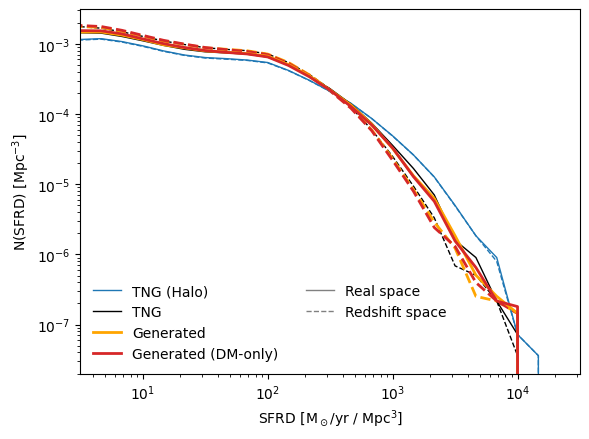

In [37]:
#plt.hist(value, range=(1, 3.5), bins=30, weights=np.ones_like(value/volume, histtype="step", label=titles[i])

plt.figure(figsize=(6, 4.5))
lw_list = [1, 1, 2, 2]
alpha = [1, 1, 1, 1]

for i, (data, header) in enumerate(zip(data_list[:4], header_list[:4])):

    boxsize = header["boxsize"] # Mpc/h
    
    x, y = calc_vid(data, boxsize)
    plt.plot(x, y, label=titles[i], color=colors[i], alpha=alpha[i], lw=lw_list[i])

    x, y = calc_vid(data_rsd_list[i], boxsize)
    plt.plot(x, y, ls="--", zorder=-10, color=colors[i], alpha=alpha[i], lw=lw_list[i])

plt.xlabel(r"${\rm SFRD\ [M_\odot / yr \ / \ Mpc^3}]$")
plt.ylabel(r"$\rm N(SFRD)\ [Mpc^{-3}]$")

plt.xscale("log")
plt.yscale("log")

xlim = plt.xlim()
ylim = plt.ylim()
xlim = (10**0.5, 10**4.5)
ylim = (2e-8, ylim[1])

plt.plot([0, 1], [ylim[0]*0.1, ylim[0]*0.1], color="gray", ls="solid", lw=1, label="Real space")
plt.plot([0, 1], [ylim[0]*0.1, ylim[0]*0.1], color="gray", ls="dashed", lw=1, label="Redshift space")
plt.xlim(xlim)
plt.ylim(ylim)

ax = plt.gca()
ax.legend(frameon=False, ncol=2)

leg = ax.get_legend()
handles = leg.legend_handles
labels = [t.get_text() for t in leg.get_texts()]
dummy, = ax.plot([],[],alpha=0)
handles.append(dummy)
labels.append("")
ax.legend(handles, labels, ncol=2, frameon=False)


fsave = "{}/intensity_histogram.pdf".format(output_dir)
my_savefig(fsave)

1223742158.py:4: RuntimeWarning: divide by zero encountered in log10
1223742158.py:4: RuntimeWarning: divide by zero encountered in log10
1223742158.py:4: RuntimeWarning: divide by zero encountered in log10
1223742158.py:4: RuntimeWarning: divide by zero encountered in log10
1223742158.py:4: RuntimeWarning: divide by zero encountered in log10
1223742158.py:4: RuntimeWarning: divide by zero encountered in log10
1223742158.py:4: RuntimeWarning: divide by zero encountered in log10
1223742158.py:4: RuntimeWarning: divide by zero encountered in log10


Saved figure to ../dataset/generated_data/figures/intensity_histogram.pdf


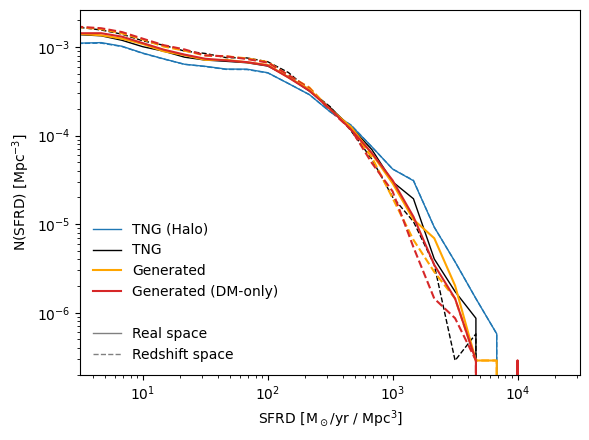

In [38]:
plt.figure(figsize=(6, 4.5))
lw_list = [1, 1, 1.5, 1.5]
alpha = [1, 1, 1, 1]

for i, (data, header) in enumerate(zip(data_list[:4], header_list[:4])):

    boxsize = header["boxsize"]*0.5# Mpc/h
    npix_half = int(len(data)/2)
    x, y = calc_vid(data[npix_half:,npix_half:,npix_half:], boxsize)
    plt.plot(x, y, label=titles[i], color=colors[i], alpha=alpha[i], lw=lw_list[i])

    x, y = calc_vid(data_rsd_list[i][npix_half:,npix_half:,npix_half:], boxsize)
    plt.plot(x, y, ls="--", zorder=-10, color=colors[i], alpha=alpha[i], lw=lw_list[i])

plt.xlabel(r"${\rm SFRD\ [M_\odot / yr \ / \ Mpc^3}]$")
plt.ylabel(r"$\rm N(SFRD)\ [Mpc^{-3}]$")

plt.xscale("log")
plt.yscale("log")

xlim = plt.xlim()
ylim = plt.ylim()
xlim = (10**0.5, 10**4.5)
ylim = (2e-7, ylim[1])

plt.plot([0, 1], [ylim[0]*0.1, ylim[0]*0.1], color="gray", ls="solid", lw=1, label="Real space")
plt.plot([0, 1], [ylim[0]*0.1, ylim[0]*0.1], color="gray", ls="dashed", lw=1, label="Redshift space")
plt.xlim(xlim)
plt.ylim(ylim)

ax = plt.gca()
ax.legend(frameon=False, ncol=2)

leg = ax.get_legend()
handles = leg.legend_handles
labels = [t.get_text() for t in leg.get_texts()]
dummy, = ax.plot([],[],alpha=0)
handles.insert(4, dummy)
labels.insert(4, "")
ax.legend(handles, labels, frameon=False)

fsave = "{}/intensity_histogram.pdf".format(output_dir)
my_savefig(fsave)

1223742158.py:4: RuntimeWarning: divide by zero encountered in log10
1223742158.py:4: RuntimeWarning: divide by zero encountered in log10
2213541248.py:28: RuntimeWarning: divide by zero encountered in divide
2213541248.py:28: RuntimeWarning: invalid value encountered in divide
1223742158.py:4: RuntimeWarning: divide by zero encountered in log10
2213541248.py:33: RuntimeWarning: divide by zero encountered in divide
2213541248.py:33: RuntimeWarning: invalid value encountered in divide
1223742158.py:4: RuntimeWarning: divide by zero encountered in log10
1223742158.py:4: RuntimeWarning: divide by zero encountered in log10
1223742158.py:4: RuntimeWarning: divide by zero encountered in log10
2213541248.py:28: RuntimeWarning: divide by zero encountered in divide
2213541248.py:28: RuntimeWarning: invalid value encountered in divide
1223742158.py:4: RuntimeWarning: divide by zero encountered in log10
2213541248.py:33: RuntimeWarning: divide by zero encountered in divide
2213541248.py:33: Runti

Saved figure to ../dataset/generated_data/figures/intensity_histogram_test_diff.pdf


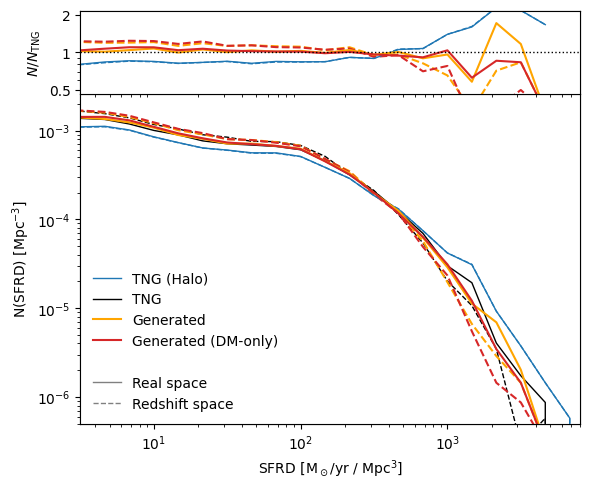

In [39]:
import matplotlib.gridspec as gridspec
    
fig = plt.figure(figsize=(6, 5))
gs = gridspec.GridSpec(2,1, height_ratios=[1,4])
gs.update(hspace=0)
plt.xticks([])
plt.yticks([])

ax = fig.add_subplot(gs[1])
ax_diff = fig.add_subplot(gs[0])

lw_list = [1, 1, 1.5, 1.5]
alpha = [1, 1, 1, 1]


boxsize = header_list[1]["boxsize"]*0.5# Mpc/h
npix_half = int(len(data_list[1])/2)
_, y_base = calc_vid(data_list[1][npix_half:,npix_half:,npix_half:], boxsize)


for i, (data, header) in enumerate(zip(data_list[:4], header_list[:4])):

    boxsize = header["boxsize"]*0.5# Mpc/h
    npix_half = int(len(data)/2)
    x, y = calc_vid(data[npix_half:,npix_half:,npix_half:], boxsize)
    ax.plot(x, y, label=titles[i], color=colors[i], alpha=alpha[i], lw=lw_list[i])
    if i != 1:
        ax_diff.plot(x, y/y_base, label=titles[i], color=colors[i], alpha=alpha[i], lw=lw_list[i])

    x, y = calc_vid(data_rsd_list[i][npix_half:,npix_half:,npix_half:], boxsize)
    ax.plot(x, y, ls="--", zorder=-10, color=colors[i], alpha=alpha[i], lw=lw_list[i])
    if i != 1:
        ax_diff.plot(x, y/y_base, ls="--", zorder=-10, color=colors[i], alpha=alpha[i], lw=lw_list[i])


ax.set_xlabel(r"${\rm SFRD\ [M_\odot / yr \ / \ Mpc^3}]$")
ax.set_ylabel(r"$\rm N(SFRD)\ [Mpc^{-3}]$")

ax.set_xscale("log")
ax.set_yscale("log")

ylim = ax.get_ylim()
xlim = (10**0.5, 8e3)
ylim = (5e-7, ylim[1])

ax.plot([0, 1], [ylim[0]*0.1, ylim[0]*0.1], color="gray", ls="solid", lw=1, label="Real space")
ax.plot([0, 1], [ylim[0]*0.1, ylim[0]*0.1], color="gray", ls="dashed", lw=1, label="Redshift space")
ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.legend(frameon=False, ncol=2)

leg = ax.get_legend()
handles = leg.legend_handles
labels = [t.get_text() for t in leg.get_texts()]
dummy, = ax.plot([],[],alpha=0)
handles.insert(4, dummy)
labels.insert(4, "")
ax.legend(handles, labels, frameon=False)

ax_diff.plot([xlim[0],xlim[1]], [1,1], ls="dotted", color=colors[1], alpha=alpha[1], lw=1)

ax_diff.set_xlim(xlim)
ax_diff.set_xscale("log")
ax_diff.set_xticks([])

ax_diff.set_yscale("log")
ax_diff.set_ylim(10**(-0.33),10**0.33)

ax_diff.set_yticks([0.5, 1, 2])
ax_diff.set_yticklabels(["0.5", "1", "2"])
import matplotlib.ticker as ticker
ax_diff.yaxis.set_minor_formatter(ticker.NullFormatter())

ax_diff.set_ylabel(r"$N/N_{\rm TNG}$")

fsave = "{}/intensity_histogram_test_diff.pdf".format(output_dir)
my_savefig(fsave)

# Plot Galaxy Catalog

In [10]:
for i, cat in enumerate(cat_list):
    plt.figure()
    plt.title(titles[i])
    
    x = cat[:, 0]
    y = cat[:, 1]
    z = cat[:, 2]

    plt.scatter(x, y, s=1, label=titles[i], alpha=0.5)
    print(len(x))

    plt.xlim(0, x.max())
    plt.ylim(0, y.max())
    ax = plt.gca()
    ax.set_aspect('equal')

In [ ]:
import numpy as np
from scipy.spatial import cKDTree

import numpy as np
from scipy.spatial import cKDTree

def two_point_cf(points, rbin, boxsize):

    N = points.shape[0]

    tree = cKDTree(points)
    pairs = tree.query_pairs(rbin[-1], output_type='ndarray')
    dists = np.linalg.norm(points[pairs[:, 0]] - points[pairs[:, 1]], axis=1)
    DD, _ = np.histogram(dists, bins=rbin)

    shell_volume = (rbin[1:]**3 - rbin[:-1]**3)
    total_volume = boxsize**3
    total_pairs = N * (N - 1) / 2
    RR = total_pairs * shell_volume / total_volume

    RR_safe = np.where(RR == 0, 1e-10, RR)
    eta = DD / RR_safe
    xi = eta - 1
    return xi

bins = np.logspace(-2, 2, 20)
bin_values = 0.5 * (bins[1:] + bins[:-1])

plt.figure(6, 4.5)

for i, cat in enumerate(cat_list):
    if i == 0:
        continue
    corr = two_point_cf(cat, bins, boxsize=205)
    plt.plot(bin_values, corr, color=colors[i], label=titles[i])

labels = ["RSD"] + [None] * 10
for i, cat in enumerate(cat_rsd_list):
    if i == 0:
        continue
    corr = two_point_cf(cat, bins, boxsize=205)
    plt.plot(bin_values, corr, color=colors[i], ls="--", label=labels[i])

plt.xscale("log")
plt.yscale("log")

xlim = plt.xlim()
ylim = plt.ylim()
plt.plot([0, 1], [ylim[0]*0.1, ylim[0]*0.1], color="gray", ls="solid", lw=1, label="Real space")
plt.plot([0, 1], [ylim[0]*0.1, ylim[0]*0.1], color="gray", ls="dashed", lw=1, label="Redshift space")
plt.xlim(xlim)
plt.ylim(ylim)


plt.xlabel(r"$\log r [{\rm Mpc}/h$")
plt.ylabel(r"$\xi(r) + 1$")    
plt.legend(frameon=False, ncol=2)


# Contribution to total intensity

Load ../dataset/generated_data/subgroup.TNG300-1.33.h5
Load ../dataset/generated_data/subgroup.TNG300-1.33.threshold1e-2.h5
Load ../dataset/generated_data/subgroup.TNG300-1.33.threshold1e-1.h5
Load ../dataset/generated_data/subgroup.TNG300-1.33.threshold1.h5
[np.float64(0.010574212205776956), np.float64(0.01056974142608914), np.float64(0.010488072330154766), np.float64(0.009725713219973082)]
0.00042297909736754846
0.00821312753293335


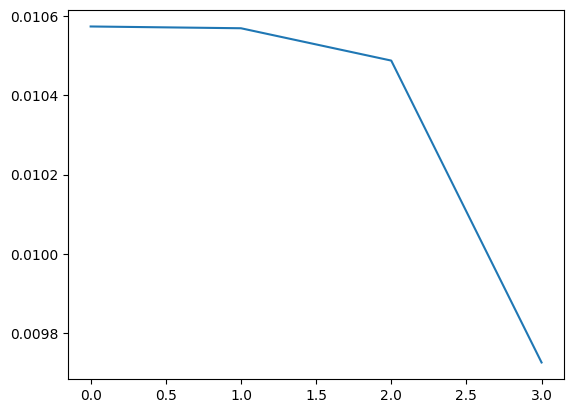

In [34]:
threshold_list = ["", ".threshold1e-2", ".threshold1e-1", ".threshold1"]
prefix = "../dataset/generated_data/subgroup.TNG300-1.33"
mean = []
for th in threshold_list:
    intensity, header = load_data(f"{prefix}{th}.h5")
    mean.append(intensity.mean())

print(mean)
plt.plot(mean)
print(mean[0]/mean[1] - 1)
print(mean[0]/mean[2] -1)